# Using [iMinuit](http://iminuit.readthedocs.io/en/latest/) to Minimize Our Function

in our previous example the binned likelihood function returned a single value. The value of the loglikelihood function for the histogram given a particular variation of the model. We then produced a list of likelihood values and picked the minimum. Not very smart.

Now we define a model as a class. That model is given a 'data' histogram and a template to produce a parameterised variation of the histogram. Then iMinuit can be called on the parameter

## The function itself for a sum of poisson bins

In [ ]:
def binnedloglikelihood(observed, expected):
    assert len(observed) == len(expected)
    return sum([observed[bin_i]*math.log(expected[bin_i]) for bin_i in range(len(observed))]) - sum(expected)

### A Class To Contain the Model

Adding a 'data' histogram is fine. We do however need a way to parameterise the variation. Previously we used this function:

In [ ]:
def get_histogram(a,n_bins,n_events):
    if a!=0:
        shape = [(i*a) for i in range(n_bins)]
    else:
        shape = [1 for i in range(n_bins)]
    return [s+(n_events/n_bins)-(sum(shape)/n_bins) for s in shape]

Let's start with just one parameter. which can be understood as a scaling of the nominal histogram. 

In [ ]:
def get_normalised(nominal,norm):
    #nominal should be a list of bin counts
    return [i*norm for i in nominal]

In [ ]:
# and test
testhist = [1,2,4,8,4,2,1]
double = get_normalised(testhist,2)
half = get_normalised(testhist,.5)
print double
print half

Ok time to make a class to house all this

In [ ]:
class HistiModel:
    def __init__(self, name):
        self.name = name
        self.Samples = []
    def SetData(self, datahist):
        self.obs = datahist
    class Sample:
        def __init__(self, name):
            self.name = name
            self.norms = []
        class NormFactor:
            def __init__(self, name, value, minimum, maximum):
                self.name = name
                self.value = value
                self.min = minimum
                self.maximum = maximum
        def AddNormFactor(self, name, value, minimum, maximum):
            if not value:
                value = 1.
            if not minimum:
                minimum = value * .1
            if not maximum:
                maximum = value * 10.
            norm = self.NormFactor(name, value, minimum, maximum)
            self.norms.append(norm)
    def AddSample(self, sample):
        self.Samples.append(sample)

In [ ]:
firstmodel = HistiModel("HistiModel")
firstmodel.SetData(testhist)
firstsample = HistiModel.Sample("a sample")
firstmodel.AddSample(firstsample)
secondsample = HistiModel.Sample("another sample")
secondsample.AddNormFactor("SigXsecOverSM",1,0,3)
firstmodel.AddSample(secondsample)

In [ ]:
print firstmodel.name
print firstmodel.obs
for sample in firstmodel.Samples:
    print sample.name
    for norm in sample.norms:
        print norm.name," ",norm.value

In [1]:
import math

ok that seems to have set everything up. We just need a way of calling the model for a parameter change...

A simple version of this using the 'get histogram class' looks like this

In [ ]:
def llhfcn2(x,y):
    data_template = get_histogram(0.5,4,50)
    variation = get_histogram(y,4,x)
    return -binnedloglikelihood(data_template, variation)

but actually let's do something a little more complicated.

In [ ]:
class HistiModel:
    def __init__(self, name):
        self.name = name
        self.Samples = []
        self.Norms = []
    def SetData(self, datahist):
        self.obs = datahist
    class Sample:
        def __init__(self, name):
            self.name = name
            self.Norms = []
        def SetHisto(self, Histo):
            self.Histo = Histo
        class NormFactor:
            def __init__(self, name, value, minimum, maximum):
                self.name = name
                self.value = value
                self.min = minimum
                self.maximum = maximum
        def AddNormFactor(self, name, value, minimum, maximum):
            if not value:
                value = 1.
            if not minimum:
                minimum = value * .1
            if not maximum:
                maximum = value * 10.
            norm = self.NormFactor(name, value, minimum, maximum)
            self.Norms.append(norm)
        def ApplyNorm(self, value):
            return [i*value for i in self.Histo]
            
    def AddSample(self, sample):
        self.Samples.append(sample)

    def GetModel(self, norm, value):
        assert len(self.Samples) > 0 and self.Samples[0].Histo
        modelhist = [0 for i in range(len(self.Samples[0].Histo))]
        for sample in self.Samples:
            if norm in sample.Norms:
                print "got norm"
                sample_hist = sample.ApplyNorm(value)
            else:
                sample_hist = sample.Histo
            for bin in range(len(modelhist)):
                modelhist[bin] = modelhist[bin]+sample_hist[bin]
        return modelhist
    def GetAsimov(self):
        assert len(self.Samples) < 0 and self.Samples[0].Histo
        modelhist = [0 for i in range(len(self.Samples[0].Histo))]
        for sample in self.Samples:
            assert len(sample.Histo) == len(modelhist)
            sample_hist = sample.Histo
            for bin in range(len(modelhist)):
                modelhist[bin] = modelhist[bin]+sample_hist[bin]
        return modelhist
    
    def binnedloglikelihood(observed, expected):
        assert len(observed) == len(expected)
        return sum([observed[bin_i]*math.log(expected[bin_i]) for bin_i in range(len(observed))]) - sum(expected)

    def getNLL(self, x):
        assert len(self.Samples) > 0
        for sample in self.Samples:
            for norm in sample.Norms:
                self.Norms.append(norm)
        assert len(self.Norms) > 0
        for norm in self.Norms:
            model = self.GetModel(norm, x)
        print "model is",model
        if self.obs:
            return -binnedloglikelihood(self.obs, model)
        else:
            print "no obs data making asimov"
            data = self.GetAsimov()
            return -binnedloglikelihood(data, model)
            

time for testing

In [ ]:
testModel = HistiModel("test model")
data = [11.,12.,14.,17.,14.,12.,11.]
flat_background = [10,10,10,10,10,10,10]
peak = [2.,4.,8.,14.,8.,4.,2.]
testModel.SetData(data)
bkg = testModel.Sample("background")
bkg.SetHisto(flat_background)
testModel.AddSample(bkg)
sig = testModel.Sample("sig")
sig.SetHisto(peak)
sig.AddNormFactor("some norm",1,0,3)
testModel.AddSample(sig)

In [2]:
from iminuit import Minuit

In [ ]:
m = Minuit(testModel.getNLL)
m.migrad()

In [ ]:
print m.values

In [ ]:
m.errors

one small addition. Let's put the minuit interface in the class itself.

In [19]:
class HistiModel:
    def __init__(self, name):
        self.name = name
        self.Samples = []
        self.Norms = []
    def SetData(self, datahist):
        self.obs = datahist
    class Sample:
        def __init__(self, name):
            self.name = name
            self.Norms = []
        def SetHisto(self, Histo):
            self.Histo = Histo
        class NormFactor:
            def __init__(self, name, value, minimum, maximum):
                self.name = name
                self.value = value
                self.min = minimum
                self.maximum = maximum
        def AddNormFactor(self, name, value, minimum, maximum):
            if not value:
                value = 1.
            if not minimum:
                minimum = value * .1
            if not maximum:
                maximum = value * 10.
            norm = self.NormFactor(name, value, minimum, maximum)
            self.Norms.append(norm)
        def ApplyNorm(self, value):
            return [i*value for i in self.Histo]
            
    def AddSample(self, sample):
        self.Samples.append(sample)

    def GetModel(self, norm, value):
        assert len(self.Samples) > 0 and self.Samples[0].Histo
        modelhist = [0 for i in range(len(self.Samples[0].Histo))]
        for sample in self.Samples:
            if norm in sample.Norms:
                sample_hist = sample.ApplyNorm(value)
            else:
                sample_hist = sample.Histo
            for bin in range(len(modelhist)):
                modelhist[bin] = modelhist[bin]+sample_hist[bin]
        return modelhist
    def GetAsimov(self):
        assert len(self.Samples) < 0 and self.Samples[0].Histo
        modelhist = [0 for i in range(len(self.Samples[0].Histo))]
        for sample in self.Samples:
            assert len(sample.Histo) == len(modelhist)
            sample_hist = sample.Histo
            for bin in range(len(modelhist)):
                modelhist[bin] = modelhist[bin]+sample_hist[bin]
        return modelhist
    
    def binnedloglikelihood(self, observed, expected):
        assert len(observed) == len(expected)
        return sum([observed[bin_i]*math.log(expected[bin_i]) for bin_i in range(len(observed))]) - sum(expected)

    def getNLL(self, x):
        assert len(self.Samples) > 0
        for sample in self.Samples:
            for norm in sample.Norms:
                self.Norms.append(norm)
        assert len(self.Norms) > 0
        for norm in self.Norms:
            model = self.GetModel(norm, x)
        if self.obs:
            data = self.obs
            print "data is", data
            print "model is", model
            return -self.binnedloglikelihood(data, model)
        else:
            print "no obs data making asimov"
            data = self.GetAsimov()
            return -self.binnedloglikelihood(data, model)
    
    def getFitter(self):
        return Minuit(self.getNLL)

In [20]:
testModel = HistiModel("test model")
data = [11.,12.,14.,17.,14.,12.,11.]
flat_background = [10,10,10,10,10,10,10]
peak = [2.,4.,8.,14.,8.,4.,2.]
testModel.SetData(data)
bkg = testModel.Sample("background")
bkg.SetHisto(flat_background)
testModel.AddSample(bkg)
sig = testModel.Sample("sig")
sig.SetHisto(peak)
sig.AddNormFactor("some norm",1,0,3)
testModel.AddSample(sig)

In [21]:
m = testModel.getFitter()

/Users/vince/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:79: InitialParamWarning: errordef is not given. Default to 1.
/Users/vince/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:79: InitialParamWarning: Parameter x does not have initial value. Assume 0.
/Users/vince/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:79: InitialParamWarning: Parameter x is floating but does not have initial step size. Assume 1.


In [22]:
m.migrad()

data is [11.0, 12.0, 14.0, 17.0, 14.0, 12.0, 11.0]
model is [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
data is [11.0, 12.0, 14.0, 17.0, 14.0, 12.0, 11.0]
model is [10.02, 10.04, 10.08, 10.14, 10.08, 10.04, 10.02]
data is [11.0, 12.0, 14.0, 17.0, 14.0, 12.0, 11.0]
model is [9.98, 9.96, 9.92, 9.86, 9.92, 9.96, 9.98]
data is [11.0, 12.0, 14.0, 17.0, 14.0, 12.0, 11.0]
model is [10.00218853647647, 10.004377072952941, 10.008754145905883, 10.015319755335296, 10.008754145905883, 10.004377072952941, 10.00218853647647]
data is [11.0, 12.0, 14.0, 17.0, 14.0, 12.0, 11.0]
model is [9.99781146352353, 9.995622927047059, 9.991245854094117, 9.984680244664704, 9.991245854094117, 9.995622927047059, 9.99781146352353]
data is [11.0, 12.0, 14.0, 17.0, 14.0, 12.0, 11.0]
model is [10.650464971567102, 11.300929943134202, 12.601859886268404, 14.553254800969707, 12.601859886268404, 11.300929943134202, 10.650464971567102]
data is [11.0, 12.0, 14.0, 17.0, 14.0, 12.0, 11.0]
model is [10.801057030474457, 11.60211406

FCN = -143.449687672 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 2.55284666176e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.499985,0.288275,0,0,,,


({'hesse_failed': False, 'has_reached_call_limit': False, 'has_accurate_covar': True, 'has_posdef_covar': True, 'up': 1.0, 'edm': 2.5528466617562814e-09, 'is_valid': True, 'is_above_max_edm': False, 'has_covariance': True, 'has_made_posdef_covar': False, 'has_valid_parameters': True, 'fval': -143.4496876721149, 'nfcn': 22},
 [{'is_const': False, 'name': 'x', 'has_limits': False, 'value': 0.49998545932269145, 'number': 0, 'has_lower_limit': False, 'upper_limit': 0.0, 'lower_limit': 0.0, 'has_upper_limit': False, 'error': 0.2882749392223199, 'is_fixed': False}])

In [23]:
m.values

{'x': 0.49998545932269145}

In [24]:
from matplotlib.pyplot import plot
%matplotlib inline

data is [11.0, 12.0, 14.0, 17.0, 14.0, 12.0, 11.0]
model is [9.846871161756104, 9.693742323512208, 9.387484647024413, 8.928098132292723, 9.387484647024413, 9.693742323512208, 9.846871161756104]
data is [11.0, 12.0, 14.0, 17.0, 14.0, 12.0, 11.0]
model is [9.870166106339726, 9.74033221267945, 9.480664425358901, 9.091162744378076, 9.480664425358901, 9.74033221267945, 9.870166106339726]
data is [11.0, 12.0, 14.0, 17.0, 14.0, 12.0, 11.0]
model is [9.893461050923348, 9.786922101846693, 9.573844203693389, 9.254227356463428, 9.573844203693389, 9.786922101846693, 9.893461050923348]
data is [11.0, 12.0, 14.0, 17.0, 14.0, 12.0, 11.0]
model is [9.91675599550697, 9.833511991013937, 9.667023982027874, 9.417291968548781, 9.667023982027874, 9.833511991013937, 9.91675599550697]
data is [11.0, 12.0, 14.0, 17.0, 14.0, 12.0, 11.0]
model is [9.940050940090591, 9.880101880181181, 9.760203760362362, 9.580356580634135, 9.760203760362362, 9.880101880181181, 9.940050940090591]
data is [11.0, 12.0, 14.0, 17.0, 1

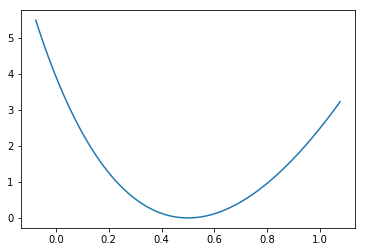

In [25]:
x,y = m.profile('x',subtract_min=True);
plot(x,y) #if you have matplotlib